In [2]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.autograd as autograd
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm.auto import tqdm, trange
import warnings
warnings.filterwarnings("ignore")

# Seed control, for better reproducibility 
# NOTE: this does not gurantee results are always the same
seed = 22
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    # work on a single GPU or CPU
    cudnn.benchmark=True
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    Tensor = torch.cuda.FloatTensor
else:
    device = torch.device("cpu")
    cudnn.benchmark=False
    Tensor = torch.FloatTensor

print(device)

EPOCHS = 50


cpu


In [3]:
def imshow(img):
    # custom show in order to display
    # torch tensors as numpy
    npimg = img.numpy() / 2 + 0.5 # from tensor to numpy
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

batch_size = 250 # might try to use large batches (we will discuss why later when we talk about BigGAN)
# NOTE: the batch_size should be an integer divisor of the data set size  or torch
# will give you an error regarding batch sizes of "0" when the data loader tries to
# load in the final batch

dataset = dset.CIFAR10(root='data/cifar/', download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                       ]))

# frogs are the sixth class in the dataset 
classes = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']
frog = 6
frog_index = [i for i, x in enumerate(dataset.targets) if x == 6]
print("number of frog imgs: ", len(frog_index))

frog_set = torch.utils.data.Subset(dataset, frog_index)


dataloader = torch.utils.data.DataLoader(frog_set, batch_size=batch_size,
                                         shuffle=True, num_workers=0)

Files already downloaded and verified
number of frog imgs:  5000


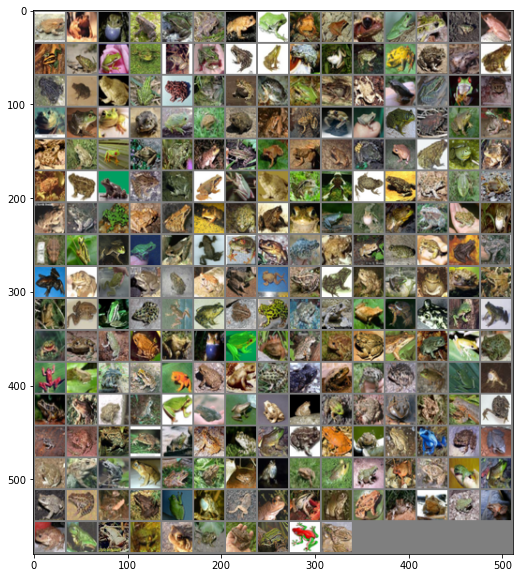

Image shape:  torch.Size([3, 32, 32])


In [10]:
# get some random training images
dataiter = iter(dataloader)
real_image_examples, _ = dataiter.next()

# show images
plt.figure(figsize=(10,10))
imshow(torchvision.utils.make_grid(real_image_examples, nrow=int(np.sqrt(batch_size))))
print("Image shape: ", real_image_examples[0].size())


# Least Squares GAN Base Architecture
In this implementation of GANS, we will use a few of the tricks from F. Chollet and from Salimans et al. In particular, we will add some noise to the labels. 

In [32]:
latent_dim = 32
height = 32
width = 32
channels = 3

# Note: according to Radford (2016), is there anything done here
# that potentially could have been different? 
# Also: adda review of BatchNorm here. 

class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()

        # First, transform the input into a 8x8 128-channels feature map
        self.init_size = width // 4 # one quarter the image size 
        self.l1 = nn.Sequential( nn.Linear(latent_dim, 128 * self.init_size ** 2) )
        # there is no reshape layer, this will be done in forward function
        # alternately we could us only the functional API
        # and bypass sequential altogether

        # we will use the sequential API
        # in order to create some blocks
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2, mode='bilinear'), #16x16
            nn.Conv2d(128, 128, 3, padding=1), #16x16

            # Then, add a convolution layer
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            # Upsample to 32x32
            nn.Upsample(scale_factor=2, mode='bilinear'), # 32x32
            nn.ConvTranspose2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            # Produce a 32x32xRGB-channel feature map
            nn.Conv2d(64, channels, kernel_size=3, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        # expand the sampled z to 8x8
        out = self.l1(z)
        out = torch.reshape(out, (out.shape[0], 128, self.init_size, self.init_size))
        # use the view function to reshape the layer output
        #  old way for earlier Torch versions: out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [33]:
class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            # dropout layer - important trick!
            nn.Dropout2d(0.25),

            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.LeakyReLU(0.3, inplace=True),
            nn.Dropout2d(0.25),
            nn.BatchNorm2d(32, 0.8),

            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.BatchNorm2d(64, 0.8),

            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.BatchNorm2d(128, 0.8),
        )

        # The height and width of downsampled image
        ds_size = width // 2 ** 4
        # Classification layer
        self.classification_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), 
                                                  nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        # use the view function to flatten the layer output
        #    old way for earlier Torch versions: out = out.view(out.shape[0], -1)
        out = torch.flatten(out, start_dim=1) # don't flatten over batch size
        validity = self.classification_layer(out)
        return validity

In [36]:
# custom weights initialization called on netG and netD
# this function from PyTorch's officail DCGAN example:
# https://github.com/pytorch/examples/blob/master/dcgan/main.py#L112
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02) # filters are zero mean, small STDev
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02) # batch norm is unit mean, small STDev
        m.bias.data.fill_(0) # like normal, biases start at zero

In [37]:
generator = Generator()
discriminator = Discriminator()

# To stabilize training, we use learning rate decay
# and gradient clipping (by value) in the optimizer.
clip_value = 1.0 # This value will use in the future training process since 
                 # PyTorch didn't has the feature to set clipvalue for 
                 # RMSprop optimizer.
# set discriminator learning higher than generator
discriminator_optimizer = torch.optim.RMSprop(discriminator.parameters(), 
                                              lr=0.0008, weight_decay=1e-8)

gan_optimizer = torch.optim.RMSprop(generator.parameters(), lr=0.0004, weight_decay=1e-8)

adversarial_loss =  torch.nn.MSELoss() # mean squared error loss 

generator.apply(weights_init)
discriminator.apply(weights_init)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout2d(p=0.25, inplace=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.3, inplace=True)
    (5): Dropout2d(p=0.25, inplace=False)
    (6): BatchNorm2d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Dropout2d(p=0.25, inplace=False)
    (10): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
    (13): Dropout2d(p=0.25, inplace=False)
    (14): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  )
  (classifi

In [38]:
iterations = EPOCHS

# Sample random points in the latent space
plot_num_examples = 25
fixed_random_latent_vectors = torch.randn(plot_num_examples, latent_dim, device=device)
img_list = []
total_steps = 0

real_image_numpy = np.transpose(torchvision.utils.make_grid(real_image_examples[:plot_num_examples,:,:,:], padding=2, normalize=False, nrow=5),(0,1,2))

In [39]:
%%time


for step in range(iterations):
    total_steps = total_steps+1
    
    pbar_2 = tqdm(enumerate(dataloader), desc='Epoch ' + str(step + 1), total=len(dataloader))

    for i, (imgs, _) in pbar_2:

        #===================================
        # GENERATOR OPTIMIZE AND GET LABELS
        
        # Zero out any previous calculated gradients
        gan_optimizer.zero_grad()

        # Sample random points in the latent space
        random_latent_vectors = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

        # Decode them to fake images, through the generator
        generated_images = generator(random_latent_vectors)

        # Assemble labels that say "all real images"
        # misleading target, c=1
        misleading_targets = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)


        # Get MSE Loss function
        # want generator output to generate images that are "close" to all "ones" 
        g_loss = adversarial_loss(discriminator(generated_images), misleading_targets)

        # now back propagate to get derivatives
        g_loss.backward()
        
        # use gan optimizer to only update the parameters of the generator
        # this was setup above to only use the params of generator
        gan_optimizer.step()

        
        #===================================
        # DISCRIMINATOR OPTIMIZE AND GET LABELS

        # Zero out any previous calculated gradients
        discriminator_optimizer.zero_grad()

        # Combine real images with some generator images
        real_images = Variable(imgs.type(Tensor))
        combined_images = torch.cat([real_images, generated_images.detach()])

        # in the above line, we "detach" the generated images from the generator
        # this is to ensure that no needless gradients are calculated 
        # those parameters wouldn't be updated (becasue we already defined the optimized parameters)
        # but they would be calculated here, which wastes time.

        # Assemble labels discriminating real from fake images
        # real label, a=1 and fake label, b=0
        labels = torch.cat((
            Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False),
            Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)
        ))
        # Add random noise to the labels - important trick!
        labels += 0.05 * torch.rand(labels.shape)

        # Setup Discriminator loss
        # this takes the average of MSE(real images labeled as real) + MSE(fake images labeled as fake)
        d_loss = (
            adversarial_loss(discriminator(combined_images[:batch_size]), labels[:batch_size]) + \
            adversarial_loss(discriminator(combined_images[batch_size:]), labels[batch_size:])
            ) / 2

        # get gradients according to loss above
        d_loss.backward()
        # optimize the discriminator parameters to better classify images
        discriminator_optimizer.step()

        # Now Clip weights of discriminator (manually)
        for p in discriminator.parameters():
            p.data.clamp_(-clip_value, clip_value)
            
        #===================================
        
    # Occasionally save / plot
    if step % 10 == 0:
        # Print metrics
        print('Loss at step %s: D(z_c)=%s, D(G(z_mis))=%s' % (total_steps, d_loss.item(),g_loss.item()))
        # save images in a list for display later
        with torch.no_grad():
            fake_output = generator(fixed_random_latent_vectors).detach().cpu()
        img_list.append(torchvision.utils.make_grid(fake_output, padding=2, normalize=True, nrow=5))
        
        # in addition, save off a checkpoint of the current models and images
        ims = np.array([np.transpose(np.hstack((i,real_image_numpy)), (2,1,0)) for i in img_list])
        np.save('models/gan_models/ls_original_images.npy',ims)

        # save the state of the models (will need to recreate upon reloading)
        torch.save({'state_dict': generator.state_dict()}, 'models/gan_models/ls_original_gen.pth')
        torch.save({'state_dict': discriminator.state_dict()}, 'models/gan_models/ls__original_dis.pth')

Epoch 1:   0%|          | 0/20 [00:00<?, ?it/s]

Loss at step 1: D(z_c)=0.19692927598953247, D(G(z_mis))=0.33889588713645935


Epoch 2:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/20 [00:00<?, ?it/s]

Loss at step 11: D(z_c)=0.24809521436691284, D(G(z_mis))=0.22494056820869446


Epoch 12:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 16:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 17:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 19:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 20:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 21:   0%|          | 0/20 [00:00<?, ?it/s]

Loss at step 21: D(z_c)=0.26530876755714417, D(G(z_mis))=0.2252448946237564


Epoch 22:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 23:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 24:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 25:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 26:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 27:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 28:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 29:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 30:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 31:   0%|          | 0/20 [00:00<?, ?it/s]

Loss at step 31: D(z_c)=0.2514413595199585, D(G(z_mis))=0.21730183064937592


Epoch 32:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 33:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 34:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 35:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 36:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 37:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 38:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 39:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 40:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 41:   0%|          | 0/20 [00:00<?, ?it/s]

Loss at step 41: D(z_c)=0.2669799327850342, D(G(z_mis))=0.16739146411418915


Epoch 42:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 43:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 44:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 45:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 46:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 47:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 48:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 49:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 50:   0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 5h 10min 25s, sys: 8min 11s, total: 5h 18min 37s
Wall time: 1h 40min 2s


In [16]:
ims = np.array([np.transpose(np.hstack((i,real_image_numpy)), (2,1,0)) for i in img_list])
np.save('models/gan_models/ls_original_images.npy',ims)

# save the state of the models (will need to recreate upon reloading)
torch.save({'state_dict': generator.state_dict()}, 'models/gan_models/ls_original_gen.pth')
torch.save({'state_dict': discriminator.state_dict()}, 'models/gan_models/ls_original_dis.pth')


In [34]:
if True:
    ims = np.load('models/gan_models/ls_original_images.npy')

    generator = Generator()
    discriminator = Discriminator()

    checkpoint = torch.load('models/gan_models/ls_original_gen.pth')
    generator.load_state_dict(checkpoint['state_dict'])

    checkpoint = torch.load('models/gan_models/ls_original_dis.pth')
    discriminator.load_state_dict(checkpoint['state_dict'])
    
    

In [18]:
def norm_grid(im):
    # first half should be normalized and second half also, separately
    im = im.astype(np.float)
    rows,cols,chan = im.shape
    cols_over2 = int(cols/2)
    tmp = im[:,:cols_over2,:]
    im[:,:cols_over2,:] = (tmp-tmp.min())/(tmp.max()-tmp.min())
    tmp = im[:,cols_over2:,:]
    im[:,cols_over2:,:] = (tmp-tmp.min())/(tmp.max()-tmp.min())
    return im



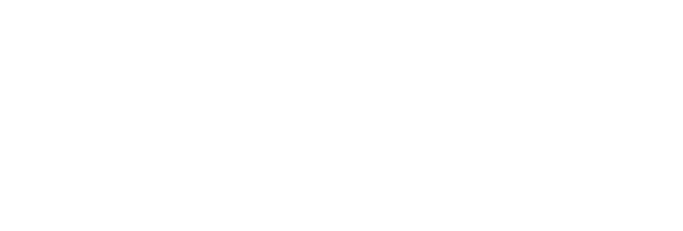

In [35]:
fig = plt.figure(figsize=(12,4))
plt.axis("off")  
pls = [[plt.imshow(norm_grid(im), animated=True)] for im in ims]
ani = animation.ArtistAnimation(fig, pls, interval=500, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())



We are getting something that is similar to a frog, but also we are seeing a bit of mode collapse. The global properties of a greenish or gray blob surrounded by various background is starting to come across. However, the finer structure is not doing too well. That is, the legs and details in the background are not present yet. 

To improve this result, there are a number of things we might try such as:
- Adding more randomization to the optimizer
- Running the discriminator multiple times for each generator update
- Changing the objective function (let's try this one)



# Improved LSGAN

First, we were asked to find any issues with the generator's architecture and fix them before running the model.  There were 2 things that we spotted: 

* ReLU activations should be used in the generator, but leaky ReLU should be used in the discriminator.
    *  Radford et al. showed in [1] that a leaky ReLU activation in the discriminator showed improvements over the ReLU activation function in the discriminator.
* A convolutional layer should be used instead of a transpose convolution
    * In class, we talked about transpose convolutions leaving more artifacts than bilinear upsampling even if the kernel size is a multiple of the stride.  To rectify this, we removed the transpose convolutional layer and added a convolutional layer in its place.  In reality, the transpose convolution that was in the network had a stride of 1 which is just a convolutional layer.  Really, it didn't make a difference, but it is more clear now.  One other thing we wanted to point out here is that you need to have the convolutional layer added if you want to keep the same architecture (batch norm, and the following conv2d) below it so that output/input dimensions match.  Simply removing the transpose convolutional layer would make the input dimension to the batch norm layer 128, but it was expecting 64 dimensions.
    
[1] https://arxiv.org/abs/1511.06434

[2]https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/#:~:text=Activation%20functions%20such%20as%20ReLU,e.g.%20lots%20of%20zero%20values).&text=The%20ReLU%20activation%20is%20used,which%20uses%20the%20Tanh%20function





### **Issue number one is that relu should be used in the gererator, but leaky relu used in the discriminator**




In [21]:
latent_dim = 32
height = 32
width = 32
channels = 3


class Generator(nn.Module):
    

    def __init__(self):
        super(Generator, self).__init__()

        # First, transform the input into a 8x8 128-channels feature map
        self.init_size = width // 4 # one quarter the image size 
        self.l1 = nn.Sequential( nn.Linear(latent_dim, 128 * self.init_size ** 2) )
        # there is no reshape layer, this will be done in forward function
        # alternately we could us only the functional API
        # and bypass sequential altogether

        # we will use the sequential API
        # in order to create some blocks
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2, mode='bilinear'), #16x16
            nn.Conv2d(128, 128, 3, padding=1), #16x16

            # Then, add a convolution layer
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.ReLU(inplace=True), # Change to relu

            # Upsample to 32x32
            nn.Upsample(scale_factor=2, mode='bilinear'), # 32x32
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
#             nn.ConvTranspose2d(128, 64, 3, padding=1), # remove
            nn.BatchNorm2d(64, 0.8),
            nn.ReLU(inplace=True), # Change to relu

            # Produce a 32x32xRGB-channel feature map
            nn.Conv2d(64, channels, kernel_size=3, padding=1),
            nn.Tanh(), 
        )

    def forward(self, z):
        # expand the sampled z to 8x8
        out = self.l1(z)
        out = torch.reshape(out, (out.shape[0], 128, self.init_size, self.init_size))
        # use the view function to reshape the layer output
        #  old way for earlier Torch versions: out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [22]:
class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            # dropout layer - important trick!
            nn.Dropout2d(0.25),

            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.LeakyReLU(0.3, inplace=True),
            nn.Dropout2d(0.25),
            nn.BatchNorm2d(32, 0.8),

            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.BatchNorm2d(64, 0.8),

            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.BatchNorm2d(128, 0.8),
        )

        # The height and width of downsampled image
        ds_size = width // 2 ** 4
        # Classification layer
        self.classification_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), 
                                                  nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        # use the view function to flatten the layer output
        #    old way for earlier Torch versions: out = out.view(out.shape[0], -1)
        out = torch.flatten(out, start_dim=1) # don't flatten over batch size
        validity = self.classification_layer(out)
        return validity

In [23]:
generator = Generator()
discriminator = Discriminator()

# To stabilize training, we use learning rate decay
# and gradient clipping (by value) in the optimizer.
clip_value = 1.0 # This value will use in the future training process since 
                 # PyTorch didn't has the feature to set clipvalue for 
                 # RMSprop optimizer.
        
# set discriminator learning higher than generator
discriminator_optimizer = torch.optim.RMSprop(discriminator.parameters(), 
                                              lr=0.0008, weight_decay=1e-8)

gan_optimizer = torch.optim.RMSprop(generator.parameters(), 
                                    lr=0.0004, weight_decay=1e-8)

# used to be: adversarial_loss = torch.nn.BCELoss() # binary cross entropy 
adversarial_loss = torch.nn.MSELoss() # mean squared error loss 

generator.apply(weights_init)
discriminator.apply(weights_init)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout2d(p=0.25, inplace=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.3, inplace=True)
    (5): Dropout2d(p=0.25, inplace=False)
    (6): BatchNorm2d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Dropout2d(p=0.25, inplace=False)
    (10): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
    (13): Dropout2d(p=0.25, inplace=False)
    (14): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  )
  (classifi

In [20]:
iterations = EPOCHS #defined above

# Sample random points in the latent space
plot_num_examples = 25
fixed_random_latent_vectors = torch.randn(plot_num_examples, latent_dim, device=device)
img_list = []
total_steps = 0

real_image_numpy = np.transpose(torchvision.utils.make_grid(real_image_examples[:plot_num_examples,:,:,:], padding=2, normalize=False, nrow=5),(0,1,2))


### Train LSGAN

In [21]:
%%time

# code is the exact same as above, no need to change it
# because we have changed the adversarial loss function
# Start training loop

# Becasue not much is changing, an interesting update would
# be to write a "train step" function and use it here.
# Something like: train_step(g, d, imgs, loss_select=MSE, num_d_steps=1)

for step in range(iterations):
    total_steps = total_steps+1
    
    pbar_2 = tqdm(enumerate(dataloader), desc='Epoch ' + str(step + 1), total=len(dataloader))

    for i, (imgs, _) in pbar_2:

        #===================================
        # GENERATOR OPTIMIZE AND GET LABELS
        
        # Zero out any previous calculated gradients
        gan_optimizer.zero_grad()

        # Sample random points in the latent space
        random_latent_vectors = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

        # Decode them to fake images, through the generator
        generated_images = generator(random_latent_vectors)

        # Assemble labels that say "all real images"
        # misleading target, c=1
        misleading_targets = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)


        # Get MSE Loss function
        # want generator output to generate images that are "close" to all "ones" 
        g_loss = adversarial_loss(discriminator(generated_images), misleading_targets)

        # now back propagate to get derivatives
        g_loss.backward()
        
        # use gan optimizer to only update the parameters of the generator
        # this was setup above to only use the params of generator
        gan_optimizer.step()

        
        #===================================
        # DISCRIMINATOR OPTIMIZE AND GET LABELS

        # Zero out any previous calculated gradients
        discriminator_optimizer.zero_grad()

        # Combine real images with some generator images
        real_images = Variable(imgs.type(Tensor))
        combined_images = torch.cat([real_images, generated_images.detach()])

        # in the above line, we "detach" the generated images from the generator
        # this is to ensure that no needless gradients are calculated 
        # those parameters wouldn't be updated (becasue we already defined the optimized parameters)
        # but they would be calculated here, which wastes time.

        # Assemble labels discriminating real from fake images
        # real label, a=1 and fake label, b=0
        labels = torch.cat((
            Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False),
            Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)
        ))
        # Add random noise to the labels - important trick!
        labels += 0.05 * torch.rand(labels.shape)

        # Setup Discriminator loss
        # this takes the average of MSE(real images labeled as real) + MSE(fake images labeled as fake)
        d_loss = (
            adversarial_loss(discriminator(combined_images[:batch_size]), labels[:batch_size]) + \
            adversarial_loss(discriminator(combined_images[batch_size:]), labels[batch_size:])
            ) / 2

        # get gradients according to loss above
        d_loss.backward()
        # optimize the discriminator parameters to better classify images
        discriminator_optimizer.step()

        # Now Clip weights of discriminator (manually)
        for p in discriminator.parameters():
            p.data.clamp_(-clip_value, clip_value)
            
        #===================================
        
    # Occasionally save / plot
    if step % 10 == 0:
        # Print metrics
        print('Loss at step %s: D(z_c)=%s, D(G(z_mis))=%s' % (total_steps, d_loss.item(),g_loss.item()))
        # save images in a list for display later
        with torch.no_grad():
            fake_output = generator(fixed_random_latent_vectors).detach().cpu()
        img_list.append(torchvision.utils.make_grid(fake_output, padding=2, normalize=True, nrow=5))
        
        # in addition, save off a checkpoint of the current models and images
        ims = np.array([np.transpose(np.hstack((i,real_image_numpy)), (2,1,0)) for i in img_list])
        np.save('models/gan_models/ls_images.npy',ims)

        # save the state of the models (will need to recreate upon reloading)
        torch.save({'state_dict': generator.state_dict()}, 'models/gan_models/ls_gen.pth')
        torch.save({'state_dict': discriminator.state_dict()}, 'models/gan_models/ls_dis.pth')
        

Epoch 1:   0%|          | 0/20 [00:00<?, ?it/s]

Loss at step 1: D(z_c)=0.2395482361316681, D(G(z_mis))=0.2332087755203247


Epoch 2:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/20 [00:00<?, ?it/s]

Loss at step 11: D(z_c)=0.249696284532547, D(G(z_mis))=0.23391886055469513


Epoch 12:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 16:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 17:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 19:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 20:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 21:   0%|          | 0/20 [00:00<?, ?it/s]

Loss at step 21: D(z_c)=0.2548055052757263, D(G(z_mis))=0.22822631895542145


Epoch 22:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 23:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 24:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 25:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 26:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 27:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 28:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 29:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 30:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 31:   0%|          | 0/20 [00:00<?, ?it/s]

Loss at step 31: D(z_c)=0.24641162157058716, D(G(z_mis))=0.2580506205558777


Epoch 32:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 33:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 34:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 35:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 36:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 37:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 38:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 39:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 40:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 41:   0%|          | 0/20 [00:00<?, ?it/s]

Loss at step 41: D(z_c)=0.2507689893245697, D(G(z_mis))=0.22500455379486084


Epoch 42:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 43:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 44:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 45:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 46:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 47:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 48:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 49:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 50:   0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 3h 6min 59s, sys: 8min 16s, total: 3h 15min 15s
Wall time: 1h 40min 34s


In [22]:
ims = np.array([np.transpose(np.hstack((i,real_image_numpy)), (2,1,0)) for i in img_list])
np.save('models/gan_models/ls_images.npy',ims)

# save the state of the models (will need to recreate upon reloading)
torch.save({'state_dict': generator.state_dict()}, 'models/gan_models/ls_gen.pth')
torch.save({'state_dict': discriminator.state_dict()}, 'models/gan_models/ls_dis.pth')


In [24]:
if True:
    ims = np.load('models/gan_models/ls_images.npy')

    generator = Generator()
    discriminator = Discriminator()

    checkpoint = torch.load('models/gan_models/ls_gen.pth')
    generator.load_state_dict(checkpoint['state_dict'])


    checkpoint = torch.load('models/gan_models/ls_dis.pth')
    discriminator.load_state_dict(checkpoint['state_dict'])

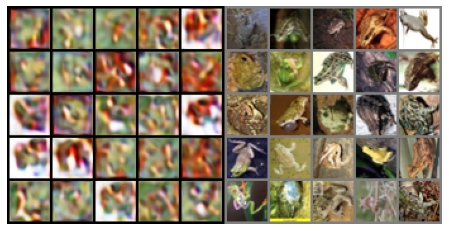

In [25]:
fig = plt.figure(figsize=(12,4))
plt.axis("off")  
pls = [[plt.imshow(norm_grid(im), animated=True)] for im in ims]
ani = animation.ArtistAnimation(fig, pls, interval=500, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

### LSGAN Results

Unfortunately, the generated frog images from the Least Squares GAN are fairly poor. In the generated images above, we see many cases of _mode collapse_ and the fine structure of the frogs is lacking to say the least. Looking back through the iterations, there are some indications of more successful generations. Subjectively, the frog structure became more apparent, however, this structure failed to stay throughout the course of the following iterations. A possivle remedy that could potentially improve the results would be to run the training process for more iterations, however, this is not guaranteed to improve the results, since GANs are inherently unstable.

# Adding Functionality to the LSGAN

## Historical Averaging

The first thing to add to the training procedure is historical averaging.  GAN architectures never converge, since the loss landscape is constantly changing due to the adversarial nature of the generator and discriminator. Furthermore, every time the generator updates its gradients, the discriminator updates its own gradient in order to be up to date with the generator at that point in time. Instead of reaching convergence, GANs attempt to reach Nash equilibrium, in which the generator and disciminator balance each other out. This search for the Nash Equilibrium can be thought of as finding a stable point in the waves of an ocean. 

The addition of _historical averaging_ will likely help the GAN reach this Nash Equilibria, or something close to it. Historical averaging makes use of previously computed weights to help guide the GAN through the loss space more effectively. Essentially, this method adds a moving average of the previously computed weights to the original loss function, as seen below.

$$L(w)_{orig} - \lambda_T \big\Vert{ w[T] - \frac{1}{n}\sum_{i=T-n}^{T-1} w[i]}\big\Vert^2$$

In [11]:
generator = Generator()
discriminator = Discriminator()

# To stabilize training, we use learning rate decay
# and gradient clipping (by value) in the optimizer.
clip_value = 1.0 # This value will use in the future training process since 
                 # PyTorch didn't has the feature to set clipvalue for 
                 # RMSprop optimizer.
        
# set discriminator learning higher than generator
discriminator_optimizer = torch.optim.RMSprop(discriminator.parameters(), 
                                              lr=0.0008, weight_decay=1e-8)

gan_optimizer = torch.optim.RMSprop(generator.parameters(), 
                                    lr=0.0004, weight_decay=1e-8)

# used to be: adversarial_loss = torch.nn.BCELoss() # binary cross entropy 
adversarial_loss = torch.nn.MSELoss() # mean squared error loss 

generator.apply(weights_init)
discriminator.apply(weights_init)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout2d(p=0.25, inplace=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.3, inplace=True)
    (5): Dropout2d(p=0.25, inplace=False)
    (6): BatchNorm2d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Dropout2d(p=0.25, inplace=False)
    (10): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
    (13): Dropout2d(p=0.25, inplace=False)
    (14): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  )
  (classifi

In [12]:
n_previous_steps = 5


# Based on code found here: https://www.kaggle.com/timetraveller98/cgan-with-historical-weight-averaging
def get_model_weights(net):
    model_weights = {}
    params = dict(net.named_parameters())
    for p in params:
        model_weights[p] = params[p].detach()    
    return model_weights

def get_normed_weight_difference(current_weights, prev_weights, params, lambda_t=10):
    prev_iters = len(prev_weights)
    
    # For each layer in the previous weights
    total_diff = 0
    for p in params:
        diff_layer = current_weights[p] - sum(step[p] for step in prev_weights)/prev_iters
        l2_diff = torch.sqrt(torch.sum(torch.square(diff_layer)))
        total_diff += l2_diff
        
    return total_diff

orig_adversarial_loss = torch.nn.MSELoss()

# Same loss as before, but add in historical averaging
def adversarial_loss(network_output, targets, current_weights, previous_weights, params):
    # No history yet
    if len(previous_weights) == 0:
        return orig_adversarial_loss(network_output, targets)
    
    historical_loss = get_normed_weight_difference(current_weights, previous_weights, params)
    return orig_adversarial_loss(network_output, targets) - historical_loss

# adversarial_loss = torch.nn.MSELoss()

### Train LSGAN with Historical Averaging

In [13]:
%%time

# code is the exact same as above, no need to change it
# because we have changed the adversarial loss function
# Start training loop

# Becasue not much is changing, an interesting update would
# be to write a "train step" function and use it here.
# Something like: train_step(g, d, imgs, loss_select=MSE, num_d_steps=1)

# Store previous weights
g_prev_weights = []
d_prev_weights = []

for step in range(iterations):
    total_steps = total_steps+1
    
    pbar_2 = tqdm(enumerate(dataloader), desc='Epoch ' + str(step + 1), total=len(dataloader))

    for i, (imgs, _) in pbar_2:

        #===================================
        # GENERATOR OPTIMIZE AND GET LABELS
        
        # Zero out any previous calculated gradients
        gan_optimizer.zero_grad()

        # Sample random points in the latent space
        random_latent_vectors = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

        # Decode them to fake images, through the generator
        generated_images = generator(random_latent_vectors)

        # Assemble labels that say "all real images"
        # misleading target, c=1
        misleading_targets = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        
        # Get the current generator weights 
        current_g_weights = get_model_weights(generator)

        # Get MSE Loss function
        # want generator output to generate images that are "close" to all "ones" 
        g_loss = adversarial_loss(discriminator(generated_images), misleading_targets, 
                                  current_g_weights, 
                                  g_prev_weights,
                                  dict(generator.named_parameters()))

        # now back propagate to get derivatives
        g_loss.backward()
        
        # use gan optimizer to only update the parameters of the generator
        # this was setup above to only use the params of generator
        gan_optimizer.step()
        
        # Add to previous weights 
        g_prev_weights.append(current_g_weights)
        
        # Store previous n steps 
        g_prev_weights = g_prev_weights[-n_previous_steps:]
        

        
        #===================================
        # DISCRIMINATOR OPTIMIZE AND GET LABELS

        # Zero out any previous calculated gradients
        discriminator_optimizer.zero_grad()

        # Combine real images with some generator images
        real_images = Variable(imgs.type(Tensor))
        combined_images = torch.cat([real_images, generated_images.detach()])

        # in the above line, we "detach" the generated images from the generator
        # this is to ensure that no needless gradients are calculated 
        # those parameters wouldn't be updated (becasue we already defined the optimized parameters)
        # but they would be calculated here, which wastes time.

        # Assemble labels discriminating real from fake images
        # real label, a=1 and fake label, b=0
        labels = torch.cat((
            Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False),
            Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)
        ))
        # Add random noise to the labels - important trick!
        labels += 0.05 * torch.rand(labels.shape)
        
        # Get the current discriminator weights 
        current_d_weights = get_model_weights(discriminator)

        # Setup Discriminator loss
        
        
        # this takes the average of MSE(real images labeled as real) + MSE(fake images labeled as fake)
        real_real_loss = adversarial_loss(discriminator(combined_images[:batch_size]),
                                          labels[:batch_size], 
                                          current_d_weights, 
                                          d_prev_weights,
                                          dict(discriminator.named_parameters()))
        fake_fake_loss = adversarial_loss(discriminator(combined_images[batch_size:]),
                                          labels[batch_size:], 
                                          current_d_weights, 
                                          d_prev_weights,
                                          dict(discriminator.named_parameters()))
        d_loss = (real_real_loss + fake_fake_loss)/2

        # get gradients according to loss above
        d_loss.backward()
        # optimize the discriminator parameters to better classify images
        discriminator_optimizer.step()
        
        # Add to previous weights 
        d_prev_weights.append(current_d_weights)
        
        # Store previous n steps 
        d_prev_weights = d_prev_weights[-n_previous_steps:]

        # Now Clip weights of discriminator (manually)
        for p in discriminator.parameters():
            p.data.clamp_(-clip_value, clip_value)
            
        #===================================
        
    # Occasionally save / plot
    if step % 10 == 0:
        # Print metrics
        print('Loss at step %s: D(z_c)=%s, D(G(z_mis))=%s' % (total_steps, d_loss.item(),g_loss.item()))
        # save images in a list for display later
        with torch.no_grad():
            fake_output = generator(fixed_random_latent_vectors).detach().cpu()
        img_list.append(torchvision.utils.make_grid(fake_output, padding=2, normalize=True, nrow=5))
        
        # in addition, save off a checkpoint of the current models and images
        ims = np.array([np.transpose(np.hstack((i,real_image_numpy)), (2,1,0)) for i in img_list])
        np.save('models/gan_models/ls_images.npy',ims)

        # save the state of the models (will need to recreate upon reloading)
        torch.save({'state_dict': generator.state_dict()}, 'models/gan_models/ls_gen.pth')
        torch.save({'state_dict': discriminator.state_dict()}, 'models/gan_models/ls_dis.pth')
        

Epoch 1:   0%|          | 0/20 [00:00<?, ?it/s]

Loss at step 1: D(z_c)=0.2481057047843933, D(G(z_mis))=0.21626809239387512


Epoch 2:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/20 [00:00<?, ?it/s]

Loss at step 11: D(z_c)=0.2494172602891922, D(G(z_mis))=0.24226540327072144


Epoch 12:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 16:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 17:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 19:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 20:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 21:   0%|          | 0/20 [00:00<?, ?it/s]

Loss at step 21: D(z_c)=0.24322044849395752, D(G(z_mis))=0.211264967918396


Epoch 22:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 23:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 24:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 25:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 26:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 27:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 28:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 29:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 30:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 31:   0%|          | 0/20 [00:00<?, ?it/s]

Loss at step 31: D(z_c)=0.25908350944519043, D(G(z_mis))=0.20697475969791412


Epoch 32:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 33:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 34:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 35:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 36:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 37:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 38:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 39:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 40:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 41:   0%|          | 0/20 [00:00<?, ?it/s]

Loss at step 41: D(z_c)=0.22653311491012573, D(G(z_mis))=0.27019983530044556


Epoch 42:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 43:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 44:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 45:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 46:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 47:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 48:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 49:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 50:   0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 1h 14s, sys: 3min 4s, total: 1h 3min 19s
Wall time: 45min 32s


In [ ]:
ims = np.array([np.transpose(np.hstack((i,real_image_numpy)), (2,1,0)) for i in img_list])
np.save('models/gan_models/ls_hist_avg_images.npy',ims)

# save the state of the models (will need to recreate upon reloading)
torch.save({'state_dict': generator.state_dict()}, 'models/gan_models/ls_hist_avg_gen.pth')
torch.save({'state_dict': discriminator.state_dict()}, 'models/gan_models/ls_hist_avg_dis.pth')


In [27]:
if True:
    ims = np.load('models/gan_models/ls_hist_avg_images.npy')

    generator = Generator()
    discriminator = Discriminator()

    checkpoint = torch.load('models/gan_models/ls_hist_avg_gen.pth')
    generator.load_state_dict(checkpoint['state_dict'])

    checkpoint = torch.load('models/gan_models/ls_hist_avg_dis.pth')
    discriminator.load_state_dict(checkpoint['state_dict'])

RuntimeError: models/gan_models/ls_hist_avg_gen.pth is a zip archive (did you mean to use torch.jit.load()?)

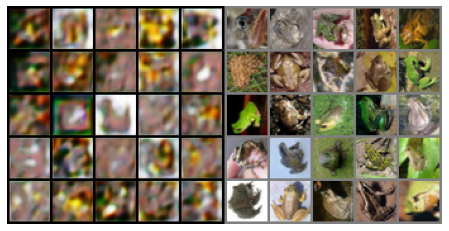

In [16]:
fig = plt.figure(figsize=(12,4))
plt.axis("off")  
pls = [[plt.imshow(norm_grid(im), animated=True)] for im in ims]
ani = animation.ArtistAnimation(fig, pls, interval=500, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

### LSGAN with Historical Averaging Results



## Feature Matching

Next we add feature matching to the Least Squares GAN architecture. Feature matching replaces the Generator's loss function with a new loss function that attempts to match the statistics of the discriminator activations. This is done by minimizing the squared difference between the mean activations of __real images__ and the mean activations of __fake images__ run through the discriminator. The feature matching loss function is only for the generator and is shown below.

$$L_G =  \big\Vert{E_{x \leftarrow data}[f(x)] - E_{x \leftarrow q(z)} [f(G(z))] }\big\Vert^2$$

In [9]:
class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            # dropout layer - important trick!
            nn.Dropout2d(0.25),

            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.LeakyReLU(0.3, inplace=True),
            nn.Dropout2d(0.25),
            nn.BatchNorm2d(32, 0.8),

            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.BatchNorm2d(64, 0.8),

            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.BatchNorm2d(128, 0.8),
        )

        # The height and width of downsampled image
        ds_size = width // 2 ** 4
        # Classification layer
        self.classification_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), 
                                                  nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        # use the view function to flatten the layer output
        #    old way for earlier Torch versions: out = out.view(out.shape[0], -1)
        out = torch.flatten(out, start_dim=1) # don't flatten over batch size
        validity = self.classification_layer(out)
        return validity, out #return out (activations) for use in feature matching

In [10]:
generator = Generator()
discriminator = Discriminator()

# To stabilize training, we use learning rate decay
# and gradient clipping (by value) in the optimizer.
clip_value = 1.0 # This value will use in the future training process since 
                 # PyTorch didn't has the feature to set clipvalue for 
                 # RMSprop optimizer.
        
# set discriminator learning higher than generator
discriminator_optimizer = torch.optim.RMSprop(discriminator.parameters(), 
                                              lr=0.0008, weight_decay=1e-8)

gan_optimizer = torch.optim.RMSprop(generator.parameters(), 
                                    lr=0.0004, weight_decay=1e-8)

# used to be: adversarial_loss = torch.nn.BCELoss() # binary cross entropy 
adversarial_loss = torch.nn.MSELoss() # mean squared error loss 

generator.apply(weights_init)
discriminator.apply(weights_init)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout2d(p=0.25, inplace=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.3, inplace=True)
    (5): Dropout2d(p=0.25, inplace=False)
    (6): BatchNorm2d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Dropout2d(p=0.25, inplace=False)
    (10): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
    (13): Dropout2d(p=0.25, inplace=False)
    (14): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  )
  (classifi

In [11]:
iterations = EPOCHS #defined above

# Sample random points in the latent space
plot_num_examples = 25
fixed_random_latent_vectors = torch.randn(plot_num_examples, latent_dim, device=device)
img_list = []
total_steps = 0

real_image_numpy = np.transpose(torchvision.utils.make_grid(real_image_examples[:plot_num_examples,:,:,:], padding=2, normalize=False, nrow=5),(0,1,2))


In [12]:
%%time

# code is the exact same as above, no need to change it
# because we have changed the adversarial loss function
# Start training loop

# Becasue not much is changing, an interesting update would
# be to write a "train step" function and use it here.
# Something like: train_step(g, d, imgs, loss_select=MSE, num_d_steps=1)

for step in range(iterations):
    total_steps = total_steps+1
    
    pbar_2 = tqdm(enumerate(dataloader), desc='Epoch ' + str(step + 1), total=len(dataloader))

    for i, (imgs, _) in pbar_2:

        #===================================
        # GENERATOR OPTIMIZE AND GET LABELS
        
        # Zero out any previous calculated gradients
        gan_optimizer.zero_grad()

        # Sample random points in the latent space
        random_latent_vectors = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

        # Decode them to fake images, through the generator
        generated_images = generator(random_latent_vectors)

        # Assemble labels that say "all real images"
        # misleading target, c=1
        misleading_targets = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)


        #----------- FEATURE MATCHING --------------
        real_images = Variable(imgs.type(Tensor))
        
        _, d_real_activations = discriminator(real_images)
        _, d_fake_activations = discriminator(generated_images)
        
        real_mean = torch.mean(d_real_activations, dim=0)
        fake_mean = torch.mean(d_fake_activations, dim=0)
        diff = real_mean-fake_mean
        g_loss = torch.mean(diff.pow(2))

        # now back propagate to get derivatives
        g_loss.backward()
        
        # use gan optimizer to only update the parameters of the generator
        # this was setup above to only use the params of generator
        gan_optimizer.step()

        
        #===================================
        # DISCRIMINATOR OPTIMIZE AND GET LABELS

        # Zero out any previous calculated gradients
        discriminator_optimizer.zero_grad()

        # Combine real images with some generator images
        combined_images = torch.cat([real_images, generated_images.detach()])

        # in the above line, we "detach" the generated images from the generator
        # this is to ensure that no needless gradients are calculated 
        # those parameters wouldn't be updated (becasue we already defined the optimized parameters)
        # but they would be calculated here, which wastes time.

        # Assemble labels discriminating real from fake images
        # real label, a=1 and fake label, b=0
        labels = torch.cat((
            Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False),
            Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)
        ))
        # Add random noise to the labels - important trick!
        labels += 0.05 * torch.rand(labels.shape)

        # Setup Discriminator loss
        # this takes the average of MSE(real images labeled as real) + MSE(fake images labeled as fake)
        d_loss = (
            adversarial_loss(discriminator(combined_images[:batch_size])[0], labels[:batch_size]) + \
            adversarial_loss(discriminator(combined_images[batch_size:])[0], labels[batch_size:])
            ) / 2

        # get gradients according to loss above
        d_loss.backward()
        # optimize the discriminator parameters to better classify images
        discriminator_optimizer.step()

        # Now Clip weights of discriminator (manually)
        for p in discriminator.parameters():
            p.data.clamp_(-clip_value, clip_value)
            
        #===================================
        
    # Occasionally save / plot
    if step % 10 == 0:
        # Print metrics
        print('Loss at step %s: D(z_c)=%s, D(G(z_mis))=%s' % (total_steps, d_loss.item(),g_loss.item()))
        # save images in a list for display later
        with torch.no_grad():
            fake_output = generator(fixed_random_latent_vectors).detach().cpu()
        img_list.append(torchvision.utils.make_grid(fake_output, padding=2, normalize=True, nrow=5))
        
        # in addition, save off a checkpoint of the current models and images
        ims = np.array([np.transpose(np.hstack((i,real_image_numpy)), (2,1,0)) for i in img_list])
        np.save('models/gan_models/ls_images.npy',ims)

        # save the state of the models (will need to recreate upon reloading)
        torch.save({'state_dict': generator.state_dict()}, 'models/gan_models/ls_gen.pth')
        torch.save({'state_dict': discriminator.state_dict()}, 'models/gan_models/ls_dis.pth')
        

Epoch 1:   0%|          | 0/20 [00:00<?, ?it/s]

Loss at step 1: D(z_c)=0.21125292778015137, D(G(z_mis))=0.00120898662135005


Epoch 2:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/20 [00:00<?, ?it/s]

Loss at step 11: D(z_c)=0.23739680647850037, D(G(z_mis))=0.0004905947716906667


Epoch 12:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 16:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 17:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 19:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 20:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 21:   0%|          | 0/20 [00:00<?, ?it/s]

Loss at step 21: D(z_c)=0.24366144835948944, D(G(z_mis))=0.00014453438052441925


Epoch 22:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 23:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 24:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 25:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 26:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 27:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 28:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 29:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 30:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 31:   0%|          | 0/20 [00:00<?, ?it/s]

Loss at step 31: D(z_c)=0.0784037634730339, D(G(z_mis))=0.00577487563714385


Epoch 32:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 33:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 34:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 35:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 36:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 37:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 38:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 39:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 40:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 41:   0%|          | 0/20 [00:00<?, ?it/s]

Loss at step 41: D(z_c)=0.2209659218788147, D(G(z_mis))=0.0013189420569688082


Epoch 42:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 43:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 44:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 45:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 46:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 47:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 48:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 49:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 50:   0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 3h 43s, sys: 8min 52s, total: 3h 9min 35s
Wall time: 1h 45min 49s


In [13]:
ims = np.array([np.transpose(np.hstack((i,real_image_numpy)), (2,1,0)) for i in img_list])
np.save('models/gan_models/ls_feat_map_images.npy',ims)

# save the state of the models (will need to recreate upon reloading)
torch.save({'state_dict': generator.state_dict()}, 'models/gan_models/ls_feat_map_gen.pth')
torch.save({'state_dict': discriminator.state_dict()}, 'models/gan_models/ls_feat_map_dis.pth')


In [29]:
if True:
    ims = np.load('models/gan_models/ls_feat_map_images.npy')

    generator = Generator()
    discriminator = Discriminator()

    checkpoint = torch.load('models/gan_models/ls_feat_map_gen.pth')
    generator.load_state_dict(checkpoint['state_dict'])

    checkpoint = torch.load('models/gan_models/ls_feat_map_dis.pth')
    discriminator.load_state_dict(checkpoint['state_dict'])

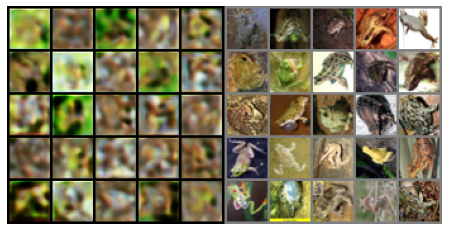

In [30]:
fig = plt.figure(figsize=(12,4))
plt.axis("off")  
pls = [[plt.imshow(norm_grid(im), animated=True)] for im in ims]
ani = animation.ArtistAnimation(fig, pls, interval=500, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

### Feature Matching Results

After adding feature matching, we see that the GAN started out really far from the target image of a frog, however, it did produce a green color. As more and more iterations passed, we started to see 'some' structure of a frog being formed. This structure was not stable over several iterations though. Compared to the original LSGAN, this model subjectively performed 'better' since it produced some notion of a frog structure and maintained the color palette throughout.

# Experience Replay

In [24]:
class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            # dropout layer - important trick!
            nn.Dropout2d(0.25),

            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.LeakyReLU(0.3, inplace=True),
            nn.Dropout2d(0.25),
            nn.BatchNorm2d(32, 0.8),

            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.BatchNorm2d(64, 0.8),

            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.BatchNorm2d(128, 0.8),
        )

        # The height and width of downsampled image
        ds_size = width // 2 ** 4
        # Classification layer
        self.classification_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), 
                                                  nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        # use the view function to flatten the layer output
        #    old way for earlier Torch versions: out = out.view(out.shape[0], -1)
        out = torch.flatten(out, start_dim=1) # don't flatten over batch size
        validity = self.classification_layer(out)
        return validity

generator = Generator()
discriminator = Discriminator()

# To stabilize training, we use learning rate decay
# and gradient clipping (by value) in the optimizer.
clip_value = 1.0 # This value will use in the future training process since 
                 # PyTorch didn't has the feature to set clipvalue for 
                 # RMSprop optimizer.
        
# set discriminator learning higher than generator
discriminator_optimizer = torch.optim.RMSprop(discriminator.parameters(), 
                                              lr=0.0008, weight_decay=1e-8)

gan_optimizer = torch.optim.RMSprop(generator.parameters(), 
                                    lr=0.0004, weight_decay=1e-8)

# used to be: adversarial_loss = torch.nn.BCELoss() # binary cross entropy 
adversarial_loss = torch.nn.MSELoss() # mean squared error loss 

generator.apply(weights_init)
discriminator.apply(weights_init)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout2d(p=0.25, inplace=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.3, inplace=True)
    (5): Dropout2d(p=0.25, inplace=False)
    (6): BatchNorm2d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Dropout2d(p=0.25, inplace=False)
    (10): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
    (13): Dropout2d(p=0.25, inplace=False)
    (14): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  )
  (classifi

In [25]:
# Modified from https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
# Modified for GANs and not RL
from collections import deque
class Experience(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, gen_images):
        self.memory.append(gen_images)

    def sample(self):
        # Returns a random memory batch
        return random.sample(self.memory, 1)[0] 

    def __len__(self):
        return len(self.memory)

In [34]:
%%time

# code is the exact same as above, no need to change it
# because we have changed the adversarial loss function
# Start training loop

# Becasue not much is changing, an interesting update would
# be to write a "train step" function and use it here.
# Something like: train_step(g, d, imgs, loss_select=MSE, num_d_steps=1)

# ------------  Experience Replay  ------------
# Create Experience object to store memories (say 40 previous batches)
experience_obj = Experience(40)


for step in range(iterations):
    total_steps = total_steps+1
    
    pbar_2 = tqdm(enumerate(dataloader), desc='Epoch ' + str(step + 1), total=len(dataloader))

    for i, (imgs, _) in pbar_2:

        #===================================
        # GENERATOR OPTIMIZE AND GET LABELS
        
        # Zero out any previous calculated gradients
        gan_optimizer.zero_grad()

        # Sample random points in the latent space
        random_latent_vectors = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

        # Decode them to fake images, through the generator
        generated_images = generator(random_latent_vectors)

        # Assemble labels that say "all real images"
        # misleading target, c=1
        misleading_targets = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)


        # Get MSE Loss function
        # want generator output to generate images that are "close" to all "ones" 
        g_loss = adversarial_loss(discriminator(generated_images), misleading_targets)

        # now back propagate to get derivatives
        g_loss.backward()
        
        # use gan optimizer to only update the parameters of the generator
        # this was setup above to only use the params of generator
        gan_optimizer.step()

        
        #===================================
        # DISCRIMINATOR OPTIMIZE AND GET LABELS

        # Zero out any previous calculated gradients
        discriminator_optimizer.zero_grad()

        # Combine real images with some generator images
        real_images = Variable(imgs.type(Tensor))
        gen_images = generated_images.detach()
        
        # ------------  Experience Replay  ------------
        # Randomly get some old "memories"
        # Only do this if we have enough experience (say 2 batches)
        if len(experience_obj) >= 2:
            memory_images = experience_obj.sample()
            combined_images = torch.cat([real_images, gen_images, memory_images])
            fake_batch_size = batch_size*2
        else:
            combined_images = torch.cat([real_images, gen_images])
            fake_batch_size = batch_size
        # Add new memories to experience
        experience_obj.push(gen_images)
        

        # in the above line, we "detach" the generated images from the generator
        # this is to ensure that no needless gradients are calculated 
        # those parameters wouldn't be updated (becasue we already defined the optimized parameters)
        # but they would be calculated here, which wastes time.

        # Assemble labels discriminating real from fake images
        # real label, a=1 and fake label, b=0
        labels = torch.cat((
            Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False),
            Variable(Tensor(fake_batch_size, 1).fill_(0.0), requires_grad=False)
        ))
        # Add random noise to the labels - important trick!
        labels += 0.05 * torch.rand(labels.shape)

        # Setup Discriminator loss
        # this takes the average of MSE(real images labeled as real) + MSE(fake images labeled as fake)
        d_loss = (
            adversarial_loss(discriminator(combined_images[:batch_size]), labels[:batch_size]) + \
            adversarial_loss(discriminator(combined_images[batch_size:]), labels[batch_size:])
            ) / 2

        # get gradients according to loss above
        d_loss.backward()
        # optimize the discriminator parameters to better classify images
        discriminator_optimizer.step()

        # Now Clip weights of discriminator (manually)
        for p in discriminator.parameters():
            p.data.clamp_(-clip_value, clip_value)
            
        #===================================
        
    # Occasionally save / plot
    if step % 10 == 0:
        # Print metrics
        print('Loss at step %s: D(z_c)=%s, D(G(z_mis))=%s' % (total_steps, d_loss.item(),g_loss.item()))
        # save images in a list for display later
        with torch.no_grad():
            fake_output = generator(fixed_random_latent_vectors).detach().cpu()
        img_list.append(torchvision.utils.make_grid(fake_output, padding=2, normalize=True, nrow=5))
        
        # in addition, save off a checkpoint of the current models and images
        ims = np.array([np.transpose(np.hstack((i,real_image_numpy)), (2,1,0)) for i in img_list])
        np.save('models/gan_models/ls_images.npy',ims)

        # save the state of the models (will need to recreate upon reloading)
        torch.save({'state_dict': generator.state_dict()}, 'models/gan_models/ls_gen.pth')
        torch.save({'state_dict': discriminator.state_dict()}, 'models/gan_models/ls_dis.pth')
        

Epoch 1:   0%|          | 0/20 [00:00<?, ?it/s]

Loss at step 58: D(z_c)=0.4803563058376312, D(G(z_mis))=9.936320566339418e-06


Epoch 2:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/20 [00:00<?, ?it/s]

Loss at step 68: D(z_c)=0.4763937294483185, D(G(z_mis))=1.8577582522993907e-05


Epoch 12:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 16:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 17:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 19:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 20:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 21:   0%|          | 0/20 [00:00<?, ?it/s]

Loss at step 78: D(z_c)=0.4775906801223755, D(G(z_mis))=7.29225212126039e-06


Epoch 22:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 23:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 24:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 25:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 26:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 27:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 28:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 29:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 30:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 31:   0%|          | 0/20 [00:00<?, ?it/s]

Loss at step 88: D(z_c)=0.47860655188560486, D(G(z_mis))=3.078144436585717e-05


Epoch 32:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 33:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 34:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 35:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 36:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 37:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 38:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 39:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 40:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 41:   0%|          | 0/20 [00:00<?, ?it/s]

Loss at step 98: D(z_c)=0.4761614203453064, D(G(z_mis))=8.258958405349404e-05


Epoch 42:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 43:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 44:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 45:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 46:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 47:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 48:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 49:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 50:   0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 1h 5min 17s, sys: 3min 1s, total: 1h 8min 19s
Wall time: 49min 11s


In [35]:
ims = np.array([np.transpose(np.hstack((i,real_image_numpy)), (2,1,0)) for i in img_list])
np.save('models/gan_models/ls_exp_replay_images.npy',ims)

# save the state of the models (will need to recreate upon reloading)
torch.save({'state_dict': generator.state_dict()}, 'models/gan_models/ls_exp_replay_gen.pth')
torch.save({'state_dict': discriminator.state_dict()}, 'models/gan_models/ls_exp_replay_dis.pth')


In [28]:
if True:
    ims = np.load('models/gan_models/ls_exp_replay_images.npy')

    generator = Generator()
    discriminator = Discriminator()

    checkpoint = torch.load('models/gan_models/ls_exp_replay_gen.pth')
    generator.load_state_dict(checkpoint['state_dict'])

    checkpoint = torch.load('models/gan_models/ls_exp_replay_dis.pth')
    discriminator.load_state_dict(checkpoint['state_dict'])

RuntimeError: models/gan_models/ls_exp_replay_gen.pth is a zip archive (did you mean to use torch.jit.load()?)

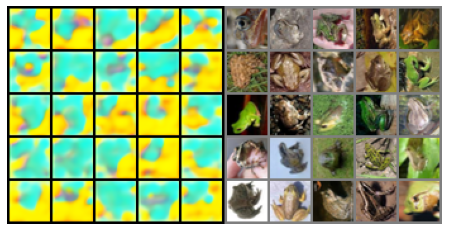

In [37]:
fig = plt.figure(figsize=(12,4))
plt.axis("off")  
pls = [[plt.imshow(norm_grid(im), animated=True)] for im in ims]
ani = animation.ArtistAnimation(fig, pls, interval=500, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())